In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
%load_ext autoreload
%autoreload 2


from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, TrainingDataSet


dataset = '20220425_Miguel'
cfg = dataset_configs[dataset]['training_20nm']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
tetra_dataset = TrainingDataSet(cfg, fit_plane_z=False, normalize_psf=False, lazy=True, transform_data=False, z_range=1000, split_data=False, add_noise=False, filter_emitters_proximity=False)
print(set(tetra_dataset.csv_data['id']))
tetra_dataset.csv_data = tetra_dataset.csv_data[tetra_dataset.csv_data['id'] == 38]
# tetra_dataset.csv_data = tetra_dataset.csv_data[tetra_dataset.csv_data['id'] == 132]

tetra_dataset.prepare_data()


Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_20nm_beads_1/2um_20nm_20nm_beads_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_20nm_beads_1/2um_20nm_20nm_beads_1_MMStack_Default.csv
{132, 165, 6, 38, 47, 16, 17, 49, 82, 92}
using image sharpness
1 emitters before filtering
1 emitters after borders


In [3]:
%load_ext autoreload
%autoreload 2


from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, TrainingDataSet


dataset = '20220425_Miguel'
cfg = dataset_configs[dataset]['training_20nm']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
tetra_dataset2 = TrainingDataSet(cfg, fit_plane_z=True, normalize_psf=True, transform_data=False, z_range=1000, split_data=False, add_noise=False, filter_emitters_proximity=False)

tetra_dataset2.prepare_debug()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_20nm_beads_1/2um_20nm_20nm_beads_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220425_Miguel/2um_20nm_20nm_beads_1/2um_20nm_20nm_beads_1_MMStack_Default.csv
using image sharpness
10 emitters before filtering
10 emitters after borders
10 emitters before filtering
10 emitters after borders


In [4]:
import numpy as np
from final_project.smlm_3d.data.visualise import grid_psfs
from sklearn.metrics import mean_absolute_error

model = load_model(load_regression_model())


pred_y = model.predict(tetra_dataset2.data['all'][0]).squeeze()
plt.rcParams['figure.figsize'] = [10, 10]

plt.scatter(tetra_dataset2.data['all'][1].squeeze(), pred_y)
plt.ylabel('Pred z (nm)')
plt.xlabel('True z (nm)')
plt.show()

errors = abs(pred_y - tetra_dataset2.data['all'][1].squeeze())
plt.boxplot(errors)
plt.title(f'MAE: {(round(np.mean(errors), 3))}')
plt.ylabel('Error (nm)')
plt.show()
errors = []

for i in range(tetra_dataset2.csv_data.shape[0]):
    fig, axs = plt.subplots(1, 2)
    psf, coords, _, _, data = tetra_dataset2.debug_emitter(i, 4000, normalize=True)
    print(data)
    coords = np.repeat(coords, psf.shape[0], axis=0)
    pred_y = model.predict((psf[:, :, :, np.newaxis], coords)).squeeze()
    pred_y -= pred_y.min()
    true_y = np.array([i*tetra_dataset2.voxel_sizes[0] for i in range(psf.shape[0])])
    
    
    mean_error = mean_absolute_error(true_y, pred_y)
    errors.append(mean_error)
    axs[0].plot(true_y, pred_y)
    axs[0].set_title(f'{str(i)}')
    axs[0].set_ylabel('Pred z (nm)')
    axs[0].set_xlabel('True z (nm)')
    axs[1].imshow(grid_psfs(psf.squeeze()))
    plt.show()

import seaborn as sns

sns.scatterplot(tetra_dataset2.csv_data['x [nm]'], tetra_dataset2.csv_data['y [nm]'], hue=errors)
plt.show()

NameError: name 'load_model' is not defined

In [5]:
import os

model_path = os.path.join('/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt', dataset)

def save_model(model):
    model.save_weights(model_path)
#     model.save(model_path, save_format='h5')
    print(model_path)
    print('Saved model!')

def load_model(model):
    print('Loading model...')
    print(model_path)
    model.load_weights(model_path).expect_partial()
    return model
#     return keras.models.load_model(model_path)

import tensorflow as tf
from tensorflow import keras

from keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from keras import Model
from keras import layers as Layers
from keras.layers import Dense, Dropout
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from final_project.smlm_3d.workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    prob_space = False
    def __init__(self, enable_dropout=False):
        super(ResNet34, self).__init__(name='ResNet34')
        self.transpose = RandomTranslation(0.1, 0.1)
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512)
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512)
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(1)

    def call(self, inp, training, enable_dropout=False):
        x, coords = inp
        
        if training:
            x = self.transpose(x)
        
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)

        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)
        
        x = self.fc1(x)
        x = self.dp1(x, training=enable_dropout)
        x = self.fc2(x)
        
        if self.prob_space:
            return x

        x = self.dp2(x, training=enable_dropout)
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x

#     def test_step(self, data):
#         (img, coords), y = data
#         y_pred = self((img, coords), training=False)

#         shifted_pred = shift_correction(y, y_pred)

#         self.compiled_loss(y, shifted_pred, regularization_losses=self.losses)
#         self.compiled_metrics.update_state(y, shifted_pred)
#         # Return a dict mapping metric names to current value.
#         # Note that it will include the loss (tracked in self.metrics).
#         return {m.name: m.result() for m in self.metrics}

    def call_with_dropout(self, inp, enable_dropout, n=5):
        preds = []
        for i in range(n):
            preds.append(self.call(inp, False, True))
        return preds


def load_regression_model():

    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    model = ResNet34()
    
#     model = res34()
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),metrics=['mean_absolute_error'])
    return model

model = load_model(load_regression_model())


Loading model...
/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt/20220425_Miguel


In [ ]:
dataset = '20220509_Fluorophore_miguel'
cfg = dataset_configs[dataset]['storm_slide']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
storm_dataset = ExperimentalDataSet(cfg, lazy=True, transform_data=False, normalize_psf=True)
storm_dataset.filter_emitters_proximity = False
storm_dataset.csv_data = storm_dataset.csv_data.sort_values('sigma [nm]', ascending=False)
storm_dataset.csv_data = storm_dataset.csv_data.iloc[0:2000]
storm_dataset.prepare_data()
plt.rcParams['figure.figsize'] = [200, 50]
plt.imshow(grid_psfs(storm_dataset.data[0].squeeze()))
plt.show()


In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.visualise import grid_psfs
from scipy.spatial.distance import cdist


from skimage.feature import blob_log
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

from skimage.filters import butterworth
def butter_psf(psf):
    # psf = remove_bg(psf)
    return np.stack([butterworth(img, 0.2, high_pass=False) for img in psf])


def is_valid_stack(img):
    center = [x//2 for x in img.shape]
    blobs = blob_log(img, max_sigma=10, min_sigma=2, threshold=.1)
    dists = cdist([center], blobs[:, [0, 1]]).squeeze()
    if len(blobs) > 0:
        fig,ax = plt.subplots(1)
        ax.set_aspect('equal')
        ax.imshow(img)
        for blob in blobs:
            y, x, r = blob
            c = Circle((x, y), r, color='red', linewidth=2, fill=False)
            ax.add_patch(c)
        ax.set_axis_off()
        plt.show()
    return len(blobs) == 1 and dists < 10 and blobs[:, 2].max() > 2



dataset = '20220509_Fluorophore_miguel'
cfg = dataset_configs[dataset]['storm_slide']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
storm_dataset = TrainingDataSet(cfg, fit_plane_z=False, normalize_psf=False, lazy=True, transform_data=False, z_range=3000, split_data=False, add_noise=False, filter_emitters_proximity=False)
storm_dataset.csv_data_bak = storm_dataset.csv_data.copy(deep=True)
storm_dataset.csv_data = storm_dataset.csv_data[storm_dataset.csv_data['sigma [nm]'] > 10]

storm_coords = storm_dataset.csv_data[['x [nm]', 'y [nm]']]

sns.scatterplot(storm_dataset.csv_data['x [nm]'], storm_dataset.csv_data['y [nm]'])
plt.show()

target = [[80000, 80000]]
dists = cdist(target, storm_coords).squeeze()
d = np.argwhere(dists < 5000).squeeze()
storm_dataset.csv_data = storm_dataset.csv_data.iloc[d]


storm_dataset.prepare_debug()

# _id = sorted(set(tetra_dataset.csv_data['id']))[0]

# tetra_dataset.csv_data = tetra_dataset.csv_data[tetra_dataset.csv_data['id'] == _id]
# tetra_dataset.prepare_data()


# target = tetra_dataset.csv_data[['x [nm]', 'y [nm]']]
# storm_coords = storm_dataset.csv_data[['x [nm]', 'y [nm]']]

# dists = cdist(target, storm_coords).squeeze()
# d = np.argwhere(dists < 10000).squeeze()
# storm_dataset.csv_data = storm_dataset.csv_data.iloc[d]
# storm_dataset.prepare_debug()


psfs = []
for i in range(storm_dataset.csv_data.shape[0]):
    psf, coords, _, _, data = storm_dataset.debug_emitter(i, 20000, normalize=False)
    
    psfs.append(psf)
    coords = np.repeat(coords, psf.shape[0], axis=0)
    if i > 50:
        break
    
psfs = np.stack(psfs)
psf = np.median(psfs, axis=0)
# psf = butter_psf(psf)
psf = storm_dataset.normalise_image(psf)

plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(grid_psfs(psf.squeeze()))
plt.show()

true_y = np.array([i*storm_dataset.voxel_sizes[0] for i in range(psf.shape[0])])

plt.rcParams['figure.figsize'] = [5, 5]

pred_y = model.predict((psf[:, :, :, np.newaxis], coords)).squeeze()
plt.scatter(true_y, pred_y)
plt.xlabel('Pred z (nm)')
plt.ylabel('True z (nm)')
plt.show()

psf = tetra_dataset.data['all'][0][0].squeeze()
psf = butter_psf(psf)
psf = storm_dataset.normalise_image(psf)
plt.imshow(grid_psfs(psf))
plt.show()

true_y = tetra_dataset.data['all'][1].squeeze()
pred_y = model.predict((psf[:, :, :, np.newaxis], tetra_dataset.data['all'][0][1])).squeeze()
plt.scatter(true_y, pred_y)
plt.xlabel('Pred z (nm)')
plt.ylabel('True z (nm)')
plt.show()


Reading img...


 76%|███████▋  | 412/539 [00:00<00:00, 2054.22it/s]

Loading /home/miguel/Projects/uni/data/smlm_3d/20220509_Fluorophore_miguel/Olympus/Well_1/2um_10nm_1/2um_10nm_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220509_Fluorophore_miguel/Olympus/Well_1/2um_10nm_1/2um_10nm_1_MMStack_Default.csv
539 emitters before filtering
539 emitters after borders


100%|██████████| 539/539 [00:00<00:00, 2052.33it/s]


Rows 5 Cols 10 n_spaces 50 n_psfs 41


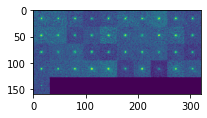

(41, 32, 32)
Loading model...
/home/miguel/Projects/uni/phd/smlm_z/final_project/smlm_3d/experiments/model_ckpt/20220425_Miguel


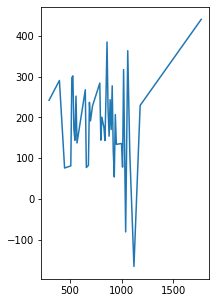

In [27]:
import matplotlib.pyplot as plt
# construct compound PSF
dataset = '20220509_Fluorophore_miguel'
cfg = dataset_configs[dataset]['storm_slide']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
storm_dataset = ExperimentalDataSet(cfg, normalize_psf=False, lazy=True, transform_data=False)
storm_dataset.filter_emitters_proximity = False
storm_dataset.csv_data_bak = storm_dataset.csv_data.copy(deep=True)
storm_dataset.csv_data = storm_dataset.csv_data[storm_dataset.csv_data['sigma [nm]'] > 10]

storm_coords = storm_dataset.csv_data[['x [nm]', 'y [nm]']]

# import seaborn as sns
# sns.kdeplot(storm_dataset.csv_data['x [nm]'], storm_dataset.csv_data['y [nm]'], fill=True)
# plt.show()

target = [[75000, 80000]]
dists = cdist(target, storm_coords).squeeze()
d = np.argwhere(dists < 10000).squeeze()
storm_dataset.csv_data = storm_dataset.csv_data.iloc[d]
storm_dataset.prepare_data()

frames = sorted(set(storm_dataset.csv_data['frame']))
psf = []
z_coords = []
for f in frames:
    psf_idx = np.argwhere(storm_dataset.csv_data['frame'].to_numpy() == f)
    if len(psf_idx) < 5:
        continue
        
    frame_imgs = storm_dataset.data[0][psf_idx].squeeze()
    if frame_imgs.ndim > 2:
        frame_imgs = np.mean(frame_imgs, axis=0)
#     plt.imshow(frame_imgs)
#     plt.title(str(f))
#     plt.show()
    
    
    psf.append(frame_imgs)
    z_coords.append(f * storm_dataset.voxel_sizes[0])

psf = np.stack(psf)
psf = storm_dataset.normalise_image(psf)
plt.imshow(grid_psfs(psf))
plt.show()
print(psf.shape)

dataset = '20220331_with_and_without_AF_long_ACQ_STORM'
model = load_model(load_regression_model())

psf = psf.squeeze()[:, :, :, np.newaxis]
coords = np.repeat(storm_dataset.convert_xy_coords_to_polar(np.array(target)), psf.shape[0], axis=0)
pred_y = model.predict((psf, coords))
plt.plot(z_coords, pred_y)
plt.show()
        

# Take all PSFs from a frame
# 



In [ ]:
import seaborn as sns
x = storm_dataset.csv_data['x [nm]']
y = storm_dataset.csv_data['y [nm]']
hue = storm_dataset.csv_data['detections']
sns.scatterplot(x, y, hue=hue)

In [6]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.data.visualise import show_psf_axial
from final_project.smlm_3d.data.visualise import grid_psfs
from final_project.smlm_3d.config.datasets import dataset_configs
from scipy.spatial.distance import cdist
from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, TrainingDataSet



dataset = '20220509_Fluorophore_miguel'
cfg = dataset_configs[dataset]['storm_slide']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
storm_dataset = TrainingDataSet(cfg, lazy=True, fit_plane_z=False, transform_data=False, z_range=3000, normalize_psf=False)
storm_dataset.csv_data_bak = storm_dataset.csv_data.copy(deep=True)
storm_dataset.filter_emitters_proximity = False

tetra_dataset.csv_data = tetra_dataset.csv_data_bak.copy(deep=True)
storm_dataset.csv_data = storm_dataset.csv_data_bak.copy(deep=True)

for _id in sorted(set(tetra_dataset.csv_data['id'])):
    print(_id)
    tetra_dataset.csv_data = tetra_dataset.csv_data[tetra_dataset.csv_data['id'] == _id]
    tetra_dataset.prepare_data()


    target = tetra_dataset.csv_data[['x [nm]', 'y [nm]']]
    storm_coords = storm_dataset.csv_data[['x [nm]', 'y [nm]']]

    dists = cdist(target, storm_coords).squeeze()
    d = np.argwhere(dists < 10000).squeeze()
    storm_dataset.csv_data = storm_dataset.csv_data.iloc[d]
    storm_dataset.prepare_debug()
    
    mean_psf = []
    plt.rcParams['figure.figsize'] = [20, 20]

    for i in range(storm_dataset.csv_data.shape[0]):
        psf = storm_dataset.debug_emitter(i, 20000, normalize=True)[0]
        show_psf_axial(psf, '', )
        mean_psf.append(psf)
    break

    psfs = np.stack(mean_psf)
    mean_psf = psfs.mean(axis=0)
    plt.imshow(grid_psfs(storm_dataset.normalise_image(mean_psf.squeeze())))
    plt.show()
    

    storm_imgs = mean_psf[:, :, :, np.newaxis]
    storm_imgs = storm_dataset.normalise_image(storm_imgs)
    storm_coords = np.repeat(storm_dataset.convert_xy_coords_to_polar(target.to_numpy()), mean_psf.shape[0], axis=0)

    storm_pred = model.predict((storm_imgs, storm_coords))
    storm_y = [i*storm_dataset.voxel_sizes[0] for i in range(storm_imgs.shape[0])]
    
    
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.plot(storm_y, storm_pred)
    plt.xlabel('Pred z (nm)')
    plt.ylabel('True z (nm)')
    plt.show()
    
    storm_dataset.csv_data = storm_dataset.csv_data_bak.copy(deep=True)
    tetra_dataset.csv_data = tetra_dataset.csv_data_bak.copy(deep=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20220509_Fluorophore_miguel/Olympus/Well_1/2um_10nm_1/2um_10nm_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20220509_Fluorophore_miguel/Olympus/Well_1/2um_10nm_1/2um_10nm_1_MMStack_Default.csv


AttributeError: 'TrainingDataSet' object has no attribute 'csv_data_bak'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
tetra_imgs, tetra_coords = tetra_dataset.data['all'][0]
tetra_imgs = tetra_imgs.squeeze()
tetra_imgs = tetra_dataset.normalise_image(tetra_imgs)[:, :, :, np.newaxis]

tetra_pred = model.predict((tetra_imgs, tetra_coords))
tetra_y = [i*tetra_dataset.voxel_sizes[0] for i in range(tetra_imgs.shape[0])]
plt.plot(tetra_y, tetra_pred)
plt.xlabel('Pred z (nm)')
plt.ylabel('True z (nm)')
plt.show()
plt.imshow(grid_psfs(tetra_imgs.squeeze()))
plt.show()

In [ ]:
from scipy.spatial.distance import cdist
dataset = '20220425_Miguel'
cfg = dataset_configs[dataset]['storm_slide']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
storm_dataset = ExperimentalDataSet(cfg, lazy=True, transform_data=False)
storm_dataset.filter_emitters_proximity = False
target = tetra_dataset.csv_data[['x [nm]', 'y [nm]']]
storm_coords = storm_dataset.csv_data[['x [nm]', 'y [nm]']]

dists = cdist(target, storm_coords).squeeze()
print(dists.min(), dists.mean(), dists.max())
d = np.argwhere(dists < 10000).squeeze()
storm_dataset.csv_data = storm_dataset.csv_data.iloc[d]

storm_dataset.prepare_data()

In [ ]:
from skimage.feature import blob_log
from matplotlib.patches import Circle
storm_imgs = storm_dataset.data[0].squeeze()
storm_z = storm_dataset.csv_data['frame'].squeeze()
storm_idx = np.argsort(storm_z)
storm_z = storm_z.to_numpy()[storm_idx]
storm_imgs = storm_imgs[storm_idx]

plt.rcParams['figure.figsize'] = [5, 5]



def is_valid_img(img, blobs):
    center = [x//2 for x in img.shape]
    dists = cdist([center], blobs[:, [0, 1]]).squeeze()
    return len(blobs) == 1 and dists < 10 and blobs[:, 2].max() > 3
    
# Show the image

keep_idx = []
def filter_storm_imgs(inp):
    i, img = inp
    blobs = blob_log(img, max_sigma=10, min_sigma=2, threshold=.1)
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2)
    if not is_valid_img(img, blobs):
        return False
    keep_idx.append(i)
#     fig,ax = plt.subplots(1)
#     ax.set_aspect('equal')
#     ax.imshow(img)
#     for blob in blobs:
#         y, x, r = blob
#         c = Circle((x, y), r, color='red', linewidth=2, fill=False)
#         ax.add_patch(c)
#     ax.set_axis_off()
#     plt.show()
    return True

keep_imgs = []
storm_imgs = np.stack(filter(filter_storm_imgs, enumerate(storm_imgs)))





In [ ]:
from final_project.smlm_3d.data.visualise import grid_psfs, show_psf_axial
plt.rcParams['figure.figsize'] = [200, 200]


plt.imshow(grid_psfs(storm_imgs))
plt.show()


tetra_imgs = tetra_dataset.data['all'][0][0].squeeze()
tetra_z = tetra_dataset.data['all'][1].squeeze()
idx = np.argsort(tetra_z).squeeze()
tetra_imgs = tetra_imgs[idx]

plt.imshow(grid_psfs(tetra_imgs))
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2


from final_project.smlm_3d.config.datasets import dataset_configs
from final_project.smlm_3d.data.datasets import GenericDataSet, ExperimentalDataSet, TrainingDataSet


dataset = 'simulated_ideal_psf'
cfg = dataset_configs[dataset]['training']
# cfg['csv'] = cfg['csv'].replace('_filtered', '')
dataset = TrainingDataSet(cfg, fit_plane_z=False, lazy=True, transform_data=True, z_range=1000, split_data=True, add_noise=True, filter_emitters_proximity=False)
dataset.prepare_data()


In [ ]:
# from sklearn.decomposition import PCA
# import seaborn as sns
# wavelets = dataset.data['train'][0][0]
# print(wavelets.shape)

# pca = PCA(n_components=10)
# dataset.data['train'][0][0] = pca.fit_transform(wavelets)
# for v in ['val', 'test']:
#     dataset.data[v][0][0] = pca.transform(dataset.data[v][0][0])

In [ ]:
from sklearn.preprocessing import Normalizer
train_norm = Normalizer()
dataset.data['train'][0][0] = train_norm.fit_transform(dataset.data['train'][0][0])
dataset.data['val'][0][0] = train_norm.transform(dataset.data['val'][0][0])
dataset.data['test'][0][0] = train_norm.transform(dataset.data['test'][0][0])

In [ ]:
# from xgboost import XGBRegressor
# import xgboost

# # XGBoost
# model_options = {
#     'n_estimators': 2000,
#     'gamma': 0,
#     'max_bin': 1024,
#     'max_depth': 8,
#     'min_child_weight': 1,
#     'verbosity': 1,
#     'tree_method': 'gpu_hist',
#     'n_jobs': 4,
#     'nthread': 4,
#     # 'subsample': 0.1,
#     # 'sampling_method': 'gradient_based',
# }

# model = XGBRegressor(**model_options, learning_rate=0.05)
# model.fit(dataset.data['train'][0][0], dataset.data['train'][1],
#           eval_metric='mae',
#           eval_set=[(dataset.data['val'][0][0], dataset.data['val'][1])],
#           early_stopping_rounds=3,
#           verbose=True,
#           )


In [ ]:
import tensorflow as tf
import numpy as np

tensor_slices = []
for d in ['train', 'val', 'test']:
    X = tf.concat(dataset.data[d][0], axis=-1)
    y = dataset.data[d][1][:, np.newaxis]
    print(X.shape, y.shape)
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(1000).batch(64)
    tensor_slices.append(ds)
    
train_dataset, val_dataset, test_dataset = tensor_slices

print(train_dataset.element_spec[0].shape[1])


In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow import keras

import tensorflow_probability as tfp

train_size = dataset.data['train'][1].shape[0]


def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

hidden_units = [1024, 1024, 1024]
learning_rate = 0.01

def create_baseline_model():
    inputs = layers.Input((X.shape[1],))
#     features = layers.BatchNormalization()(features)
    features = inputs

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation='sigmoid')(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def create_probablistic_bnn_model():
    inputs = layers.Input((X.shape[1],))
    features = layers.BatchNormalization()(inputs)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
#     ls = [
#         layers.Input(shape=(X.shape[1],)),
#         layers.BatchNormalization(),
#         *[tfp.layers.DenseVariational(
#             units=units,
#             make_prior_fn=prior,
#             make_posterior_fn=posterior,
#             kl_weight=1 / train_size,
#             activation="sigmoid",
#         ) for units in hidden_units],
#         layers.Dense(units=2),
#         tfp.layers.IndependentNormal(1)
#     ]
    
#     model = Sequential(ls)
    return model

model = create_baseline_model()
model.build(input_shape=(X.shape[1],))
print(model.summary())

In [ ]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

num_epochs = 1000

learning_rate = 0.01
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss='mse',
    metrics=[keras.metrics.RootMeanSquaredError()],
)

print("Start training the model...")
model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset, verbose=True)
print("Model training finished.")
_, rmse = model.evaluate(train_dataset, verbose=0)
print(f"Train RMSE: {round(rmse, 3)}")

print("Evaluating model performance...")
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test RMSE: {round(rmse, 3)}")



In [ ]:
return

In [ ]:
"""
Title: Probabilistic Bayesian Neural Networks
Author: [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)
Date created: 2021/01/15
Last modified: 2021/01/15
Description: Building probabilistic Bayesian neural network models with TensorFlow Probability.
"""

"""
## Introduction

Taking a probabilistic approach to deep learning allows to account for *uncertainty*,
so that models can assign less levels of confidence to incorrect predictions.
Sources of uncertainty can be found in the data, due to measurement error or
noise in the labels, or the model, due to insufficient data availability for
the model to learn effectively.


This example demonstrates how to build basic probabilistic Bayesian neural networks
to account for these two types of uncertainty.
We use [TensorFlow Probability](https://www.tensorflow.org/probability) library,
which is compatible with Keras API.

This example requires TensorFlow 2.3 or higher.
You can install Tensorflow Probability using the following command:

```python
pip install tensorflow-probability
```
"""

"""
## The dataset

We use the [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality)
dataset, which is available in the [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/wine_quality).
We use the red wine subset, which contains 4,898 examples.
The dataset has 11numerical physicochemical features of the wine, and the task
is to predict the wine quality, which is a score between 0 and 10.
In this example, we treat this as a regression task.

You can install TensorFlow Datasets using the following command:

```python
pip install tensorflow-datasets
```
"""

"""
## Setup
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

"""
## Create training and evaluation datasets

Here, we load the `wine_quality` dataset using `tfds.load()`, and we convert
the target feature to float. Then, we shuffle the dataset and split it into
training and test sets. We take the first `train_size` examples as the train
split, and the rest as the test split.
"""


def get_train_and_test_splits(train_size, batch_size=1):
    # We prefetch with a buffer the same size as the dataset because th dataset
    # is very small and fits into memory.
    dataset = (
        tfds.load(name="wine_quality", as_supervised=True, split="train")
        .map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=dataset_size)
        .cache()
    )
    # We shuffle with a buffer the same size as the dataset.
    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset


"""
## Compile, train, and evaluate the model
"""

hidden_units = [8, 8]
learning_rate = 0.001


def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")


"""
## Create model inputs
"""

FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]


def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs



# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


"""
We use the `tfp.layers.DenseVariational` layer instead of the standard
`keras.layers.Dense` layer in the neural network model.
"""


def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model




def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


"""
Since the output of the model is a distribution, rather than a point estimate,
we use the [negative loglikelihood](https://en.wikipedia.org/wiki/Likelihood_function)
as our loss function to compute how likely to see the true data (targets) from the
estimated distribution produced by the model.
"""


def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)


num_epochs = 1000
prob_bnn_model = create_probablistic_bnn_model(train_size)
print(prob_bnn_model.summary())
run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)

"""
Now let's produce an output from the model given the test examples.
The output is now a distribution, and we can use its mean and variance
to compute the confidence intervals (CI) of the prediction.
"""

prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        f" - Actual: {targets[idx]}"
    )
